# An example for GPinv.linear_model

This notebook briefly shows an inference example for non-linear model

*Keisuke Fujii 5th Sept. 2016*

## Synthetic observation

Consider we observe a cylindrical transparent mediam with multiple ($N$) lines-of-sight, as shown below.

<img src=cylindrical.png>

The local emission intensity $f$ is a function of the radius $r$.
The observed emission intensity $\mathbf{T}$ is a result of the integration along the line-of-sight as
$$
\mathbf{Y} = \int_{x} g(r) dx + \mathbf{e}
$$

where $\mathbf{e}$ is a i.i.d. Gaussian noise.

We divided $g$ into $n$ discrete points $\mathbf{f}$, then the above integration can be approximated as follows
$$
\mathbf{Y} = \mathrm{A} \mathbf{g} + \mathbf{e}
$$

We assume 
$$
g(r) = \exp(f(r))
$$
where $f(r)$ follows the Gaussian Process with kernel $\mathrm{K}$, 
for satisfying the positive solution of $\mathbf{g}$.

Therefore, this problem is non-linear.

In this notebook, we estimate $\mathbf{g}$ by MCMC.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('../testing/')
from test_linear_model import make_LosMatrix

## Latent functions

In [2]:
n = 30
N = 40
# radial coordinate
r = np.linspace(0, 1., n)
# synthetic latent function
f = np.exp(-(r-0.3)*(r-0.3)/0.1) + np.exp(-(r+0.3)*(r+0.3)/0.1)

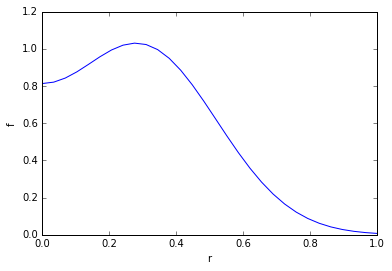

In [3]:
# plotting the latent function
plt.plot(r, f)
plt.xlabel('r')
plt.ylabel('f')

## Synthetic experiment

In [4]:
# los height
z = np.linspace(-0.9,0.9, N)
# Los-matrix
A = make_LosMatrix(r, z)

In [7]:
# noise amplitude 
e_amp = 0.1
# synthetic observation
y = np.dot(A, f) + e_amp * np.random.randn(N)

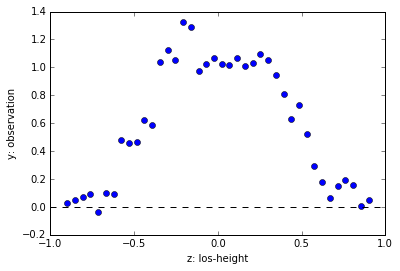

In [8]:
plt.plot(z, y, 'o', [-1,1],[0,0], '--k')
plt.xlabel('z: los-height')
plt.ylabel('y: observation')

# Typical Usage

In [13]:
import GPinv
import GPflow

## Likelihood

For attacking this non-linear model, we need to construct a custom-likelihood to express $p(\mathbf{Y}|\mathbf{g})$.

In [19]:
import tensorflow as tf

class AbelLikelihood(GPinv.likelihoods.StochasticLikelihood):
    def __init__(self, Amat, num_stocastic_points=20):
        GPinv.likelihoods.StochasticLikelihood.__init__(self, num_stocastic_points)

        self.Amat = GPflow.param.DataHolder(Amat)
        self.variance = GPflow.param.Param(np.ones(1), GPflow.transforms.positive)

    def logp(self, X, Y):
        """
        :param list of tensor Xlist: list of the latent functions with length Q.
                The shape of the i-th element is [Ni,M]
        :param list of tensor Ylist: list of the observations with length P.
                The shape of the i-th element is [Ni',M']
        :return list of log of the likelihood with length P.
            The shape should be the same to that of Ylist.
        """
        F = tf.matmul(self.Amat, tf.exp(X))
        Y = Y
        return GPflow.densities.gaussian(Y, F, self.variance)

In [20]:
likelihood = AbelLikelihood(A)

## Kernel

We need small jitter for the numericall stability.

In [21]:
kern = GPinv.kernels.RBF_csym(1) + GPinv.kernels.White(1)
# jitter variance
kern.white.variance = 1.0e-4

In [22]:
model = GPinv.nonlinear_model.GPMC(r.reshape(-1,1), y.reshape(-1,1), 
                                   kern = kern,
                                   mean_function = GPinv.mean_functions.Constant(np.ones(1)),
                                   likelihood=likelihood)

## Sampling

In [45]:
samples = model.sample(1000, burn=1000, verbose=True)

burn-in sampling started
Iteration:  100 	 Acc Rate:  95.0 %
Iteration:  200 	 Acc Rate:  96.0 %
Iteration:  300 	 Acc Rate:  95.0 %
Iteration:  400 	 Acc Rate:  97.0 %
Iteration:  500 	 Acc Rate:  93.0 %
Iteration:  600 	 Acc Rate:  96.0 %
Iteration:  700 	 Acc Rate:  92.0 %
Iteration:  800 	 Acc Rate:  66.0 %
Iteration:  900 	 Acc Rate:  91.0 %
Iteration:  1000 	 Acc Rate:  90.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  83.0 %
Iteration:  200 	 Acc Rate:  91.0 %
Iteration:  300 	 Acc Rate:  78.0 %
Iteration:  400 	 Acc Rate:  72.0 %
Iteration:  500 	 Acc Rate:  77.0 %
Iteration:  600 	 Acc Rate:  89.0 %
Iteration:  700 	 Acc Rate:  93.0 %
Iteration:  800 	 Acc Rate:  85.0 %
Iteration:  900 	 Acc Rate:  84.0 %
Iteration:  1000 	 Acc Rate:  74.0 %


## Predicting the latent functions

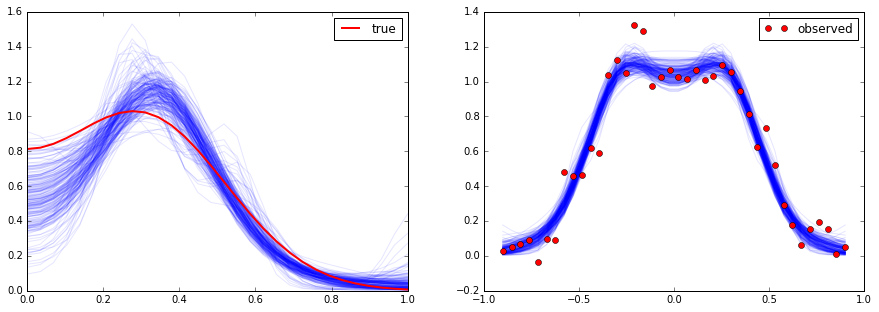

In [46]:
r_new = np.linspace(0.,1., 30)

plt.figure(figsize=(15,5))
for s in samples[::5]:
    model.set_state(s)
    f_pred = model.predict_f(r_new.reshape(-1,1))
    plt.subplot(1,2,1)
    plt.plot(r_new, np.exp(f_pred[0]),'b', alpha=0.1)
    plt.subplot(1,2,2)
    plt.plot(z, np.dot(A, np.exp(f_pred[0])),'b', alpha=0.1)

plt.subplot(1,2,1)
plt.plot(r, f, '-r', label='true',lw=2)
plt.plot([0,1],[0,0],'--k')
plt.legend()

plt.subplot(1,2,2)
plt.plot(z, y, 'ro',lw=2, label='observed')
plt.legend()